<a href="https://colab.research.google.com/github/pedrojosefernandez1/RL_FCPSSL/blob/main/MetodosAproximados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio del Comportamiento de Algoritmos de Aprendizaje por Refuerzo por Métodos Aproximado

````
Author: Jaime Pujante Sáez
Email: jaime.pujantes@um.es

Author: Ricardo Javier Sendra Lázaro
Email: ricardojavier.sendral@um.es

Author: Pedro José Fernandez Campillo
Email: pedrojose.fernandez1@um.es
````

En este notebook, se analizará el comportamiento de distintos algoritmos de aprendizaje por refuerzo basados en métodos aproximados, tales como:
- **SARSA semi-gradiente**
- **Deep Q-Learning**

El objetivo es evaluar su desempeño en un entorno del framework **Gymnasium**.
## Preparación del entorno
### 1. Clonación del repositorio e instalación de dependencias
Para comenzar, clonamos el repositorio con la implementación de los algoritmos y luego instalamos las dependencias necesarias:


In [ ]:
import os
from urllib.parse import urlparse

GITHUB_REPO_URL = "https://github.com/pedrojosefernandez1/RL_FCPSSL.git"
# Extraer usuario y nombre del repositorio automáticamente
def obtener_usuario_y_repo(url):
    path = urlparse(url).path.strip('/')
    parts = path.split('/')
    if len(parts) >= 2:
        return parts[0], parts[1]
    return None, None

GITHUB_USERNAME, GITHUB_REPO_NAME = obtener_usuario_y_repo(GITHUB_REPO_URL)
GITHUB_REPO_NAME = GITHUB_REPO_NAME.replace('.git', '')
if not GITHUB_USERNAME or not GITHUB_REPO_NAME:
    raise ValueError("URL del repositorio inválida. Asegúrate de que sea de GitHub y tenga el formato correcto.")

REPO_NAME = GITHUB_REPO_NAME  # Nombre de la carpeta después de clonar

# Clonar el repositorio si no existe
os.makedirs(REPO_NAME, exist_ok=True)
if not os.path.exists(os.path.join(REPO_NAME, ".git")):
    ! git clone {GITHUB_REPO_URL} {REPO_NAME}

# Verificar si existe un archivo requirements.txt para instalar dependencias
req_file = os.path.join(REPO_NAME, "requirements.txt")
if os.path.exists(req_file):
    ! pip install -r {req_file}

### 2. Importación de librerías necesarias
Una vez instaladas las dependencias, importamos las librerías requeridas para el análisis:

In [41]:
! pip install -r requirements.txt
! pip install "gymnasium[classic-control]"

  Using cached pygame-2.6.1-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached pygame-2.6.1-cp312-cp312-win_amd64.whl (10.6 MB)


In [1]:
import random
import collections
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from gymnasium.wrappers import RecordVideo
import os
import sys
from tqdm import tqdm

SEED = 32

np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

os.environ['PYTHONHASHSEED'] = str(SEED)

sys.path.append('src')

print(sys.path)

from plotting import plot_episode_rewards_subplot, plot_len_episodes_subplot
from agents.approximation_methods.tile import TileCodingFeatureExtractor
from agents.approximation_methods.sarsa.sarsa_semi_gradient_epsilongreedy import SarsaSemiGradientEpsilonGreedyAgent

['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv', '', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv\\Lib\\site-packages', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Pedro\\Desktop\\EXML\\RL_FCPSSL\\.venv\\Lib\\site-packages\\Pythonwin', 'src']


In [9]:
N_EPISODES = 5000

env_cartpole = gym.make("CartPole-v1", render_mode="rgb_array")

low_cartpole = env_cartpole.observation_space.low.copy()
high_cartpole = env_cartpole.observation_space.high.copy()
# Ajustar límites para las dimensiones con valores infinitos:
# Por ejemplo, para la velocidad del carro y la velocidad angular se pueden usar [-3, 3]
low_cartpole[1] = -3.0
low_cartpole[3] = -3.0
high_cartpole[1] = 3.0
high_cartpole[3] = 3.0

env_mountaincar = gym.make('MountainCar-v0', 
                    render_mode="rgb_array", max_episode_steps=500)
low_mountaincar = env_mountaincar.observation_space.low.copy()
high_mountaincar = env_mountaincar.observation_space.high.copy()

In [ ]:
# Definir los valores de epsilon, alpha y gamma
epsilon_values = [0.2, 0.7]  # Menos explorador y más explorador
alpha_values = [0.05, 0.01]  # Menos agresivo y más agresivo
gamma_values = [0.999] # Alta valoración futura


# Definir los entornos y sus nombres
environments = {
    "CartPole": env_cartpole,
    "MountainCar": env_mountaincar
}

feature_extractors = {
    "CartPole": TileCodingFeatureExtractor(num_tilings=8, low=low_cartpole, high=high_cartpole, iht_size=2048),
    "MountainCar": TileCodingFeatureExtractor(num_tilings=8, low=low_mountaincar, high=high_mountaincar, iht_size=2048)
}


agents_info = []

for env_name, env in environments.items():
    for epsilon in epsilon_values:
        for alpha in alpha_values:
            for gamma in gamma_values:
                agent = SarsaSemiGradientEpsilonGreedyAgent(env, epsilon=epsilon, gamma=gamma, alpha=alpha, epsilon_decay=0.9995, alpha_decay=0.9995, min_epsilon=0, min_alpha=0, feature_extractor=feature_extractors[env_name])   
                agents_info.append({
                    "agent": agent,
                    "environment": env_name,
                    "epsilon": epsilon,
                    "alpha": alpha,
                    "gamma": gamma
                })
                #agent = DQNAgent(env, lr=alpha, gamma=gamma, epsilon_start=epsilon, epsilon_decay=0.9995, min_epsilon=0, buffer_capacity=10000, batch_size=64, target_update_freq=10, device='cpu')
                #agents_info.append({
                #    "agent": agent,
                #    "environment": env_name,
                #    "epsilon": epsilon,
                #    "alpha": alpha,
                #    "gamma": gamma
                #})
stats_list = []

for info in agents_info:
    agent = info["agent"]
    print (info["environment"])

    agent.train(N_EPISODES, render_interval=500, video_path='videos')º
    # Guardar estadísticas con el metadata asociado
    stats_list.append({
        "environment": info["environment"],
        "epsilon": info["epsilon"],
        "alpha": info["alpha"],
        "gamma": info["gamma"],
        "stats": agent.stats()
    })
del agents_info

CartPole
0.05 0.2 0 0 0.9995 0.9995 2048 8


 20%|██        | 1000/5000 [00:23<02:02, 32.58it/s]

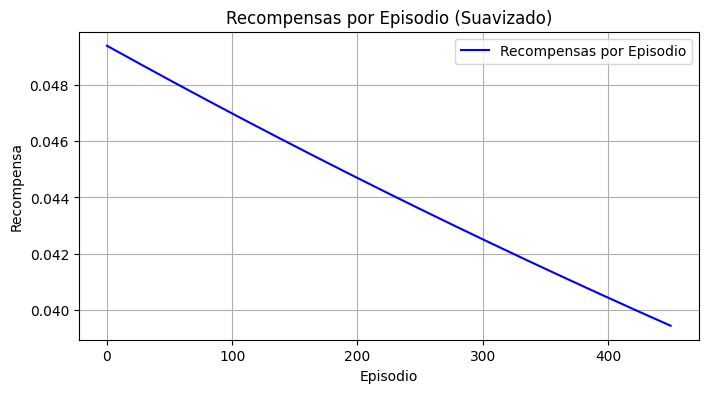

In [8]:
from plotting.plotting import plot_episode_rewards 
plot_episode_rewards(stats_list[0]["stats"]["alpha_history"])

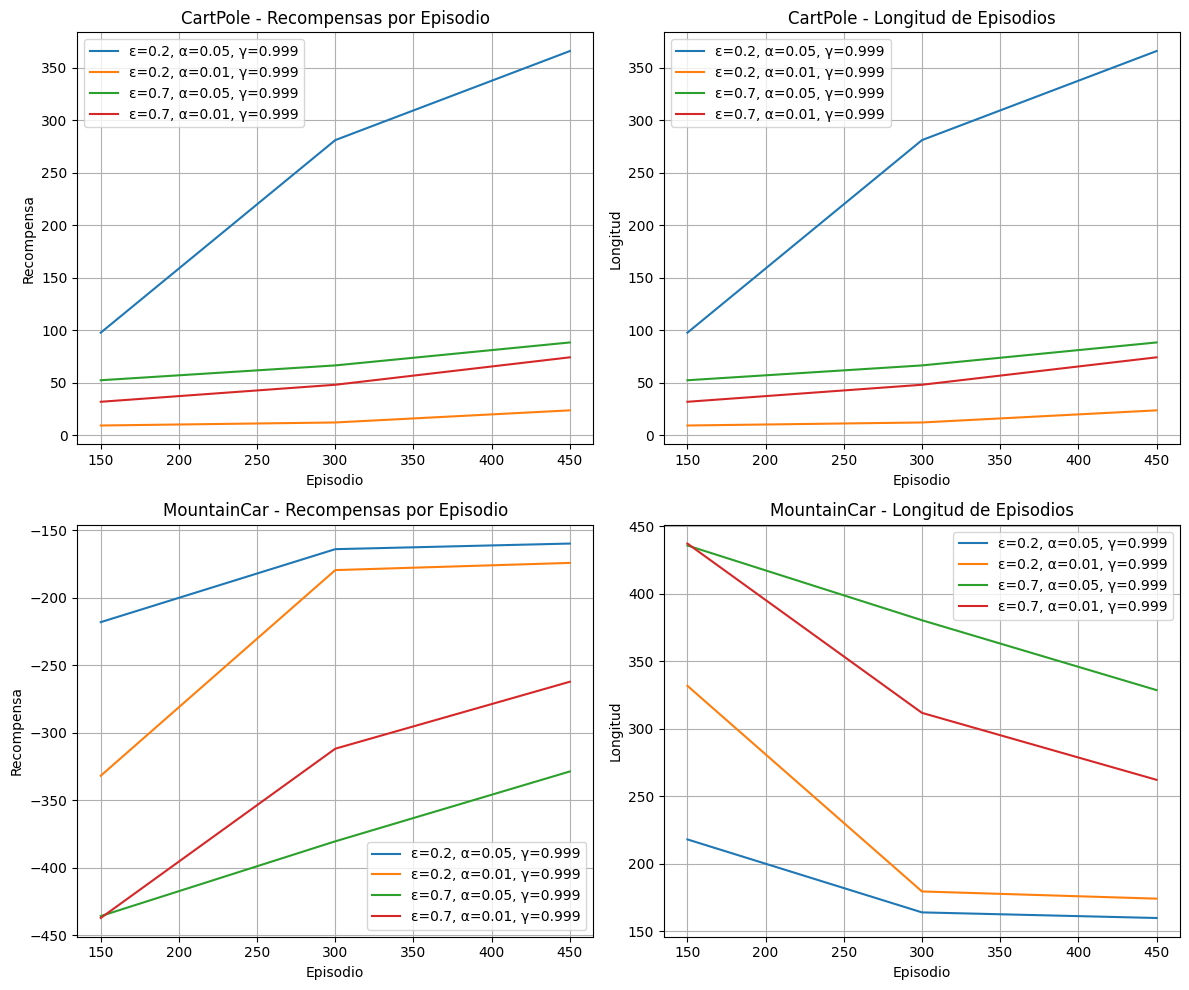

In [7]:
import matplotlib.pyplot as plt

n_media=150

# Agrupar estadísticas por environment
env_stats = {}
for entry in stats_list:
    env_name = entry["environment"]
    if env_name not in env_stats:
        env_stats[env_name] = []
    env_stats[env_name].append(entry)  # Guardamos todas las configuraciones de epsilon/alpha

# Crear subplots dinámicos según el número de entornos
num_envs = len(env_stats)
fig, axes = plt.subplots(num_envs, 2, figsize=(12, 5 * num_envs))  # (filas, columnas)

# Si solo hay un entorno, convertir `axes` en una lista para evitar errores de indexación
if num_envs == 1:
    axes = [axes]

# Generar gráficos por cada entorno
for idx, (env_name, env_entries) in enumerate(env_stats.items()):
    ax1, ax2 = axes[idx]  # Obtener los ejes de la fila correspondiente

    # Primera columna: Recompensas por episodio
    plt.sca(ax1)  # Establecer el eje activo en ax1
    for entry in env_entries:
        label = f"ε={entry['epsilon']}, α={entry['alpha']}, γ={entry['gamma']}"
        plot_episode_rewards_subplot(entry["stats"]["episode_rewards"], n_media=n_media, ax=ax1)  # Usar tu función
    ax1.set_title(f"{env_name} - Recompensas por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.legend([f"ε={e['epsilon']}, α={e['alpha']}, γ={e['gamma']}" for e in env_entries])  # Leyenda con α y ε

    # Segunda columna: Longitud de episodios
    plt.sca(ax2)  # Establecer el eje activo en ax2
    for entry in env_entries:
        plot_len_episodes_subplot(entry["stats"]["episodes"], n_media=n_media, ax=ax2)  # Usar tu función
    ax2.set_title(f"{env_name} - Longitud de Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Longitud")
    ax2.legend([f"ε={e['epsilon']}, α={e['alpha']}, γ={e['gamma']}" for e in env_entries])  # Leyenda con α y ε

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()
